In [1]:
%pylab
%matplotlib inline

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


Объявляем всякие полезные константы:
1. $a$ — ширина широкой секции волновода, $M$ — число учитываемых мод
2. $b$ — ширина узкой секции волновода, $N$ — число учитываемых мод
3. $f$ — частота (на самом деле, используется параметр $f = F/c_0$, критическое значение параметра $f_c = \frac{1}{2 a}$)

In [162]:
a = 1.000+0j; M = 100
b = 0.500+0j; N = 100
f = 3.0

assert(abs(a) >= abs(b))

Собственная функция $$f_n^a (x) = \sqrt{\frac{2}{a}} \cos {\frac{\pi n x}{a}} $$

In [163]:
def eigenfunction(n, a, x):
    n = 2*n + 1
    return sqrt(2.0/a) * cos(pi * n * x/a)

Матричный элемент (считаем, что $a \ge b$) $$V_{mn} = \int\limits_{-b/2}^{b/2} f_m^a (x) f_n^b(x) d x = 
\begin{cases}
\frac{4}{\pi} b^{-3/2} a^{-1/2} n \frac{(-1)^{(n-1)/2}}{\left(\frac{n}{b}\right)^2 - \left(\frac{m}{a}\right)^2} \cos{\left(\frac{\pi}{2} \frac{b}{a} m\right)},\ если \frac{n}{b} \ne \frac{m}{a} \\
\frac{b}{a}\ в~противном~случае
\end{cases}
$$ 


In [164]:
def _V(a, b, m, n):
    _n = n
    m = 2*m + 1
    n = 2*n + 1
    if (m/a == n/b):
        return sqrt(b/a)
    else:
        return 4.0/pi * b**(-1.5) * a**(-0.5) * n * (-1)**_n * cos(0.5*pi*b/a*m) / ((n/b)**2 - (m/a)**2)
    
V = vectorize(_V)

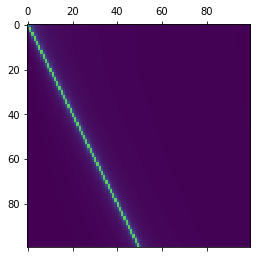

In [165]:
Vmn = fromfunction(lambda m, n: V(a, b, m, n), (M, N))
matshow(abs(Vmn))

На всякий случай проверим напрямую интегрированием

In [166]:
do_numeric_verification = False

if do_numeric_verification:
    from scipy.integrate import quad
    tmp = lambda m, n: quad(lambda x: eigenfunction(m, a, x) * eigenfunction(n, b, x), -a/2, a/2)[0]
    verif_Vmn = fromfunction(vectorize(tmp), (M, N))
    assert(allclose(Vmn, verif_Vmn))

Теперь — коэффициенты в уравнениях для магнитных полей $\Gamma(n, a)$

In [167]:
def Gamma(n, a):
    n = 2*n + 1
    return sqrt(1.0 - (n/(a*f))**2)

Gamma_a = fromfunction(lambda n: Gamma(n, a), (M,))
Gamma_b = fromfunction(lambda n: Gamma(n, b), (N,))

Коэффициенты в уравнении
\begin{equation}
\begin{cases}
\mathbf{A} \left( A^{(1)}) + B^{(1)} \right) = \mathbf{B} \left(A^{(2)} + B^{(2)}\right)\ (электрическое~поле) \\
\mathbf{C} \left( -A^{(1)} + B^{(1)} \right) = \mathbf{D} \left(A^{(2)} - B^{(2)}\right)\ (магнитное~поле)
\end{cases}
\end{equation}

Размерности матриц:
1. $A$ — $M \times M$
2. $B$ — $M \times N$
3. $C$ — $N \times M$
4. $D$ — $N \times N$

Таким образом, вполне определены только $A^{-1}$ и $D^{-1}$

In [168]:
A = eye(M)
#B = fromfunction(lambda m, n: V(a, b, m, n), (M, N))
B = Vmn
#C = fromfunction(lambda n, m: Gamma(m, a)/Gamma(n, b) * V(a, b, m, n), (N, M))
C = Vmn.T * Gamma_a/Gamma_b.reshape(-1, 1)
D = eye(N)

# проверяем размерности матриц
assert(A.shape == (M, M))
assert(B.shape == (M, N))
assert(C.shape == (N, M))
assert(D.shape == (N, N))

Для определения обобщенной $S$-матрицы запишем исходные уравнения для согласования мод так
$$
\begin{bmatrix}
\mathbf{A} & \mathbf{-B} \\
\mathbf{C} & \mathbf{D}
\end{bmatrix}
\begin{pmatrix}
B^{1} \\
B^{2}
\end{pmatrix}
=
\begin{bmatrix}
\mathbf{-A} & \mathbf{B} \\
\mathbf{C} & \mathbf{D}
\end{bmatrix}
\begin{pmatrix}
A^{1} \\
A^{2}
\end{pmatrix}
$$

Левую матрицу обозначим $P$, правую — $Q$. Их размерности — $(M+N) \times (M+N)$. Искомая $S$ - матрица
$$
S = 
\begin{bmatrix}
S_{11} & S_{12} \\
S_{21} & S_{22}
\end{bmatrix}
= \mathbf{P}^{-1} \mathbf{Q}
$$

Размерности матриц
1. $S_{11}$ — $M \times M$

In [169]:
P = zeros((M+N, M+N), dtype = complex)
P[0:M, 0:M] = A
P[0:M, M:M+N] = -B
P[M:M+N, 0:M] = C
P[M:M+N, M:M+N] = D

Q = zeros((M+N, M+N), dtype = complex)
Q[0:M, 0:M] = -A
Q[0:M, M:M+N] = B
Q[M:M+N, 0:M] = C
Q[M:M+N, M:M+N] = D


In [170]:
S = dot(inv(P), Q)

S11 = S[0:M, 0:M]
S12 = S[0:M, M:(M+N)]
S21 = S[M:(M+N), 0:M]
S22 = S[M:(M+N), M:(M+N)]

Посчитаем матрицу рассеяния напрямую (без блочных матриц) и сравним результаты:

In [171]:
X = dot(inv(A), B)
Y = dot(inv(D), C)
XY = dot(X, Y)
YX = dot(Y, X)

vS11 = dot(inv(eye(M) + XY), -eye(M) + XY)
vS12 = 2 * dot(inv(eye(M) + XY), X)
vS21 = 2 * dot(inv(eye(N) + YX), Y)
vS22 = dot(inv(eye(N) + YX), eye(N) - YX)

In [172]:
assert(allclose(vS11, S11))
assert(allclose(vS12, S12))
assert(allclose(vS21, S21))
assert(allclose(vS22, S22))

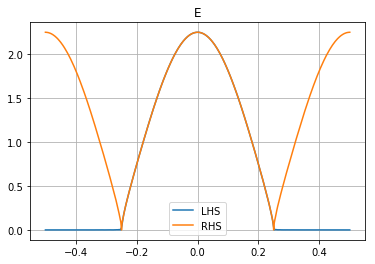

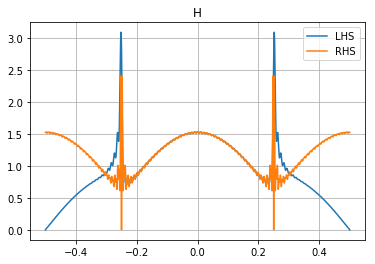

In [181]:
x = linspace(-0.5, 0.5, num=1001, dtype = complex)

a1 = zeros(M); a1[0] = 1.0 
b1 = dot(S11, a1)
lhsE = 0j
lhsH = 0j

for i in xrange(M):
    lhsE += a1[i] * eigenfunction(i, a, x)
    lhsE += b1[i] * eigenfunction(i, a, x)
    lhsH += -Gamma(i, a) * a1[i] * eigenfunction(i, a, x)
    lhsH += +Gamma(i, a) * b1[i] * eigenfunction(i, a, x)

b2 = dot(S21, a1)
rhsE = 0j
rhsH = 0j
for i in xrange(N):
    rhsE += b2[i] * eigenfunction(i, b, x)
    rhsH += -Gamma(i, b) * b2[i] * eigenfunction(i, b, x)
    
figure()
plot(x, abs(lhsE), label="LHS")
plot(x, abs(rhsE), label="RHS")
legend()
title("E")
grid()

figure()
plot(x, abs(lhsH), label="LHS")
plot(x, abs(rhsH), label="RHS")
legend()
title("H")
grid()

In [174]:
from IPython.display import HTML, display
def display_array(A, fmt = "%3.3f"):
    """
    Вывести в виде HTML-таблицы абсолютные значения матрицы A
    """
    html = []
    html.append("<table>")
    (i_max, j_max) = A.shape
    for i in xrange(i_max):
        html.append("<tr>")
        ll = []
        for j in xrange(j_max):
            ll.append(("<td>" + fmt + "</td>") % abs(A[i, j]))
        html.append("".join(ll))
        html.append("</tr>")
    html.append("</table>")
    html_page = "".join(html)
    display(HTML(html_page))

Поглядим, что с балансом энергии:

In [175]:
S_rhs = dot(Gamma_a, (a1)**2 - (b1)**2)
S_lhs = dot(Gamma_b, (b2)**2)

print abs((S_rhs - S_lhs)/(S_rhs + S_lhs))

nan


/usr/lib64/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in cdouble_scalars


In [176]:
20*log10(abs(S11[0,0]))

-25.397872914991449